### 6-4. Skip Connection (ResNet)

In [1]:
# 모델을 만드는 데에 필요한 모듈 불러오기
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model

2025-03-02 18:44:33.365243: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-02 18:44:33.373977: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-02 18:44:33.391111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740908673.418427   10700 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740908673.426722   10700 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 18:44:33.459298: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
def residual_module(input_layer, n_filters):  
	merge_input = input_layer

    # if문에서는 채널 사이즈가 동일한지 확인하고, 만일 동일하지 않다면 1x1 convolution을 통해서 채널 사이즈를 맞춰 준다.
	if input_layer.shape[-1] != n_filters:
		merge_input = keras.layers.Conv2D(n_filters, (1,1), padding='same', activation='relu')(input_layer) # n_filter로 채널 사이즈를 맞춰 준다.
	# Conv2D layer
	conv1 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(input_layer)
	# Conv2D layer
	conv2 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='linear')(conv1)
	
    # Add를 통해서 skip connection을 구현하는 부분
	out_layer = keras.layers.Add()([conv2, merge_input])
	out_layer = keras.layers.Activation('relu')(out_layer)
 
	return out_layer

In [3]:
input = keras.layers.Input(shape=(256, 256, 3))
residual_out = residual_module(input, 64)

2025-03-02 18:44:38.294228: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
print(residual_out)

<KerasTensor shape=(None, 256, 256, 64), dtype=float32, sparse=False, name=keras_tensor_5>


In [5]:
model = keras.models.Model(inputs=input, outputs=residual_out)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 256, 256, 64)      │          36,928 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 64)      │             256 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256, 256, 64)      │               0 │ conv2d_2[0][0],            │
│                               │                           │                 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 256, 256, 64)      │               0 │ add[0][0]                  │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,976 (152.25 KB)

 Trainable params: 38,976 (152.25 KB)

 Non-trainable params: 0 (0.00 B)

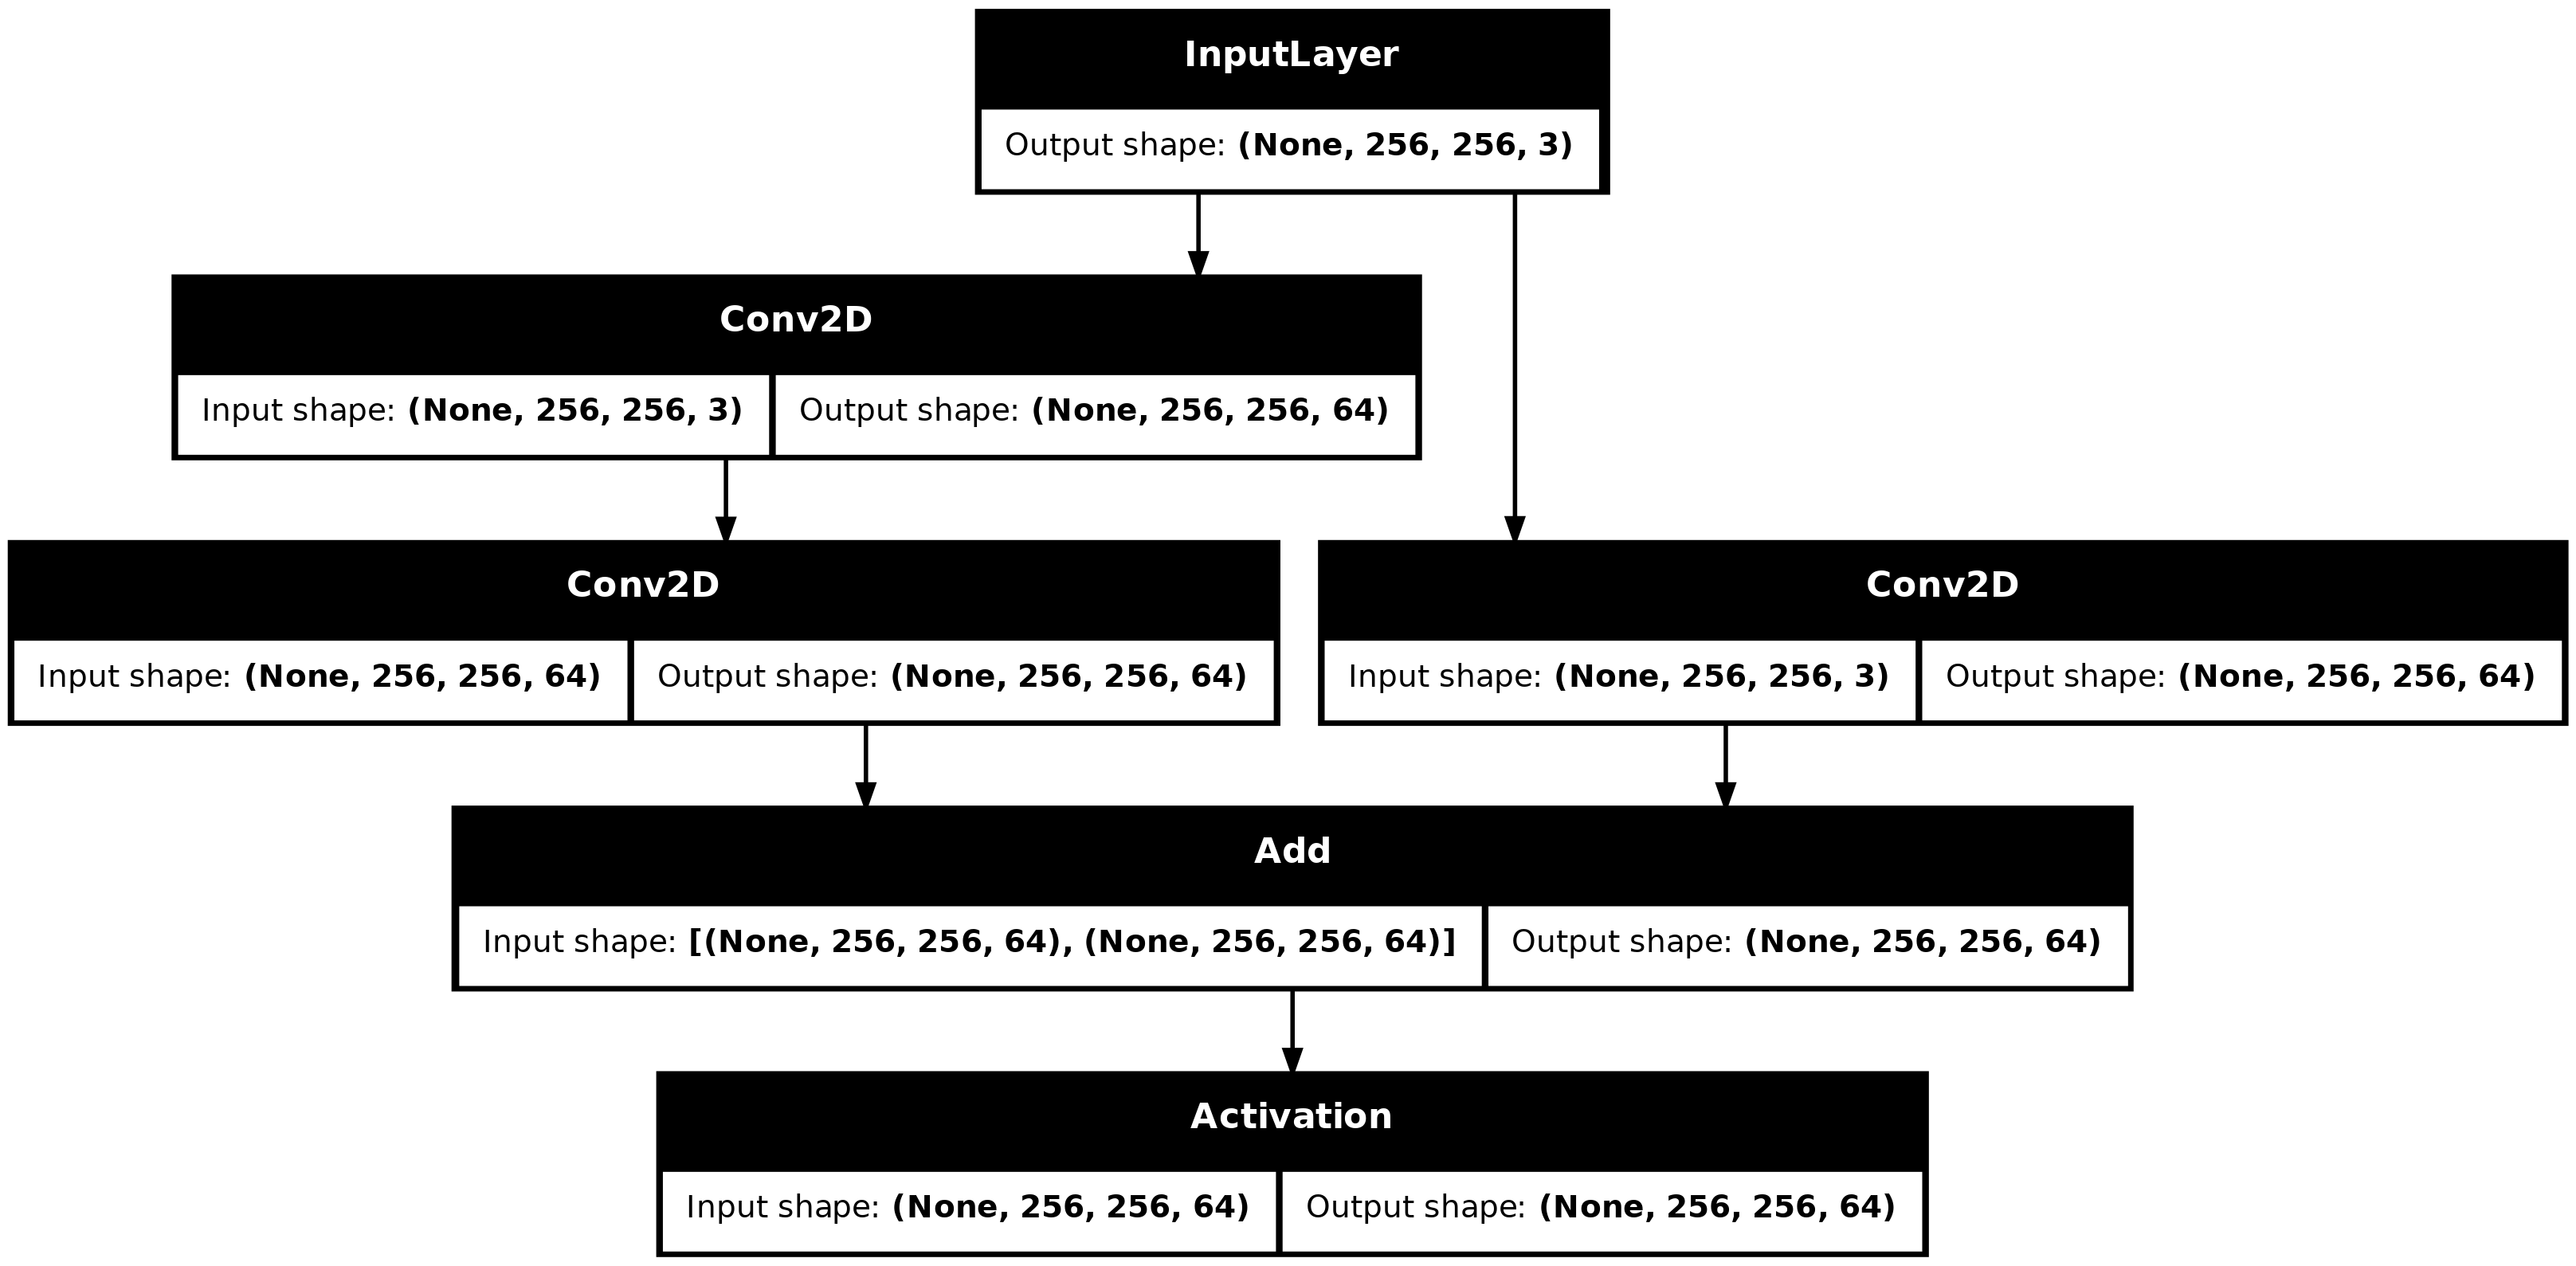

In [6]:
plot_model(model, show_shapes=True, to_file='output/residual_module.png')